# Imports

Import libraries

In [ ]:
import torch
import torchvision
import os
import time
import glob
import pickle
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler, WeightedRandomSampler
from torchvision import transforms, utils
from PIL import Image
from math import prod
from statistics import mean
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, hamming_loss, confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# GCS Bucket Set up

In [ ]:
project_id = 'responsive-cab-442307-s0'
bucket_name = 'deskbrainsec'

In [ ]:
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=l6VwyNw19tIyCgmPuMkEceCe1asHHC&prompt=consent&token_usage=remote&access_type=offline&code_challenge=muziLt5cq5ms1suhgMAKWxV2E9VeMm5xtOjFaU2hSsM&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AeanS0YuhFkXWD2EASk3l7vsRQP4hT4K5Ljl-HIUdkgFP0f-E81mjc2nl1HAd6K0bT19oQ

You are now logged in as [oshen@ucdavis.edu].
Your current project is [

In [ ]:
!pwd

/content


In [ ]:
!gcloud config set project {project_id}
!gsutil cp gs://{bucket_name}/tiles.zip tiles.zip
!gsutil cp gs://{bucket_name}/wmgm-split.zip wmgm-split.zip
!gsutil cp gs://{bucket_name}/wmgm-small.zip wmgm-small.zip
!gsutil cp gs://{bucket_name}/tiles-small-imabalance.zip tiles-small-imbalance.zip

Updated property [core/project].
Copying gs://deskbrainsec/tiles.zip...
- [1 files][  3.0 GiB/  3.0 GiB]   64.0 MiB/s                                   
Operation completed over 1 objects/3.0 GiB.                                      
Copying gs://deskbrainsec/wmgm-split.zip...
| [1 files][152.0 MiB/152.0 MiB]                                                
Operation completed over 1 objects/152.0 MiB.                                    
Copying gs://deskbrainsec/wmgm-small.zip...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
Copying gs://deskbrainsec/tiles-small-imabalance.zip...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


In [ ]:
!unzip -u 'tiles.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/tiles' '/content/'
!rm -r '/content/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_83.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_18.jpg_12.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_101.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_15.jpg_32.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_9_18.jpg_17.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_17.jpg_73.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_52.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/til

In [ ]:
!unzip -u 'wmgm-split.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/wmgm-split' '/content/'
!rm -r '/content/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA5010-02_AB17-24_13824_24832_14080_25088_97.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA4993-02_AB17-24_4352_21504_4608_21760_84.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4626-02_AB_0_27392_256_27648_107.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4691-02_AB_0_11776_256_12032_46.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/gm_NA4972-02_AB17-24_1792_41984_2048_42240_164.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA4626-02_AB_3328_23552_3584_23808_92.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA5010-02_AB17-24_0_3328_256_3584_13.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4695-02_AB_25

In [ ]:
!unzip -u 'wmgm-small.zip' -d '/content/'
!unzip -u 'tiles-small-imbalance.zip' -d '/content/'
!mv 'train-small.csv' '/content/wmgm-split/'
!mv 'validation-small.csv' '/content/wmgm-split/'
!mv 'train-small-imbalance.csv' '/content/tiles/'
!mv 'validation-small-imbalance.csv' '/content/tiles/'

Archive:  wmgm-small.zip
Archive:  tiles-small-imbalance.zip


# Google Drive Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Change environment directory to DeskBrainSec folder in Google Drive. This is for persistent file storage.

In [ ]:
%cd '/content/drive/MyDrive/DeskBrainSec/'

/content/drive/MyDrive/DeskBrainSec


Unzip datasets into local VM.

In [ ]:
!unzip -u 'tiles.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/tiles' '/content/'
!rm -r '/content/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_83.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_18.jpg_12.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_101.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_15.jpg_32.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_9_18.jpg_17.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_17.jpg_73.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_52.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/til

In [ ]:
!unzip -u 'wmgm-split.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/wmgm-split' '/content/'
!rm -r '/content/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA5010-02_AB17-24_13824_24832_14080_25088_97.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA4993-02_AB17-24_4352_21504_4608_21760_84.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4626-02_AB_0_27392_256_27648_107.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4691-02_AB_0_11776_256_12032_46.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/gm_NA4972-02_AB17-24_1792_41984_2048_42240_164.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA4626-02_AB_3328_23552_3584_23808_92.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA5010-02_AB17-24_0_3328_256_3584_13.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4695-02_AB_25

In [ ]:
!cp '/content/drive/MyDrive/DeskBrainSec/tiles/train-small-imbalance.csv' '/content/tiles/'
!cp '/content/drive/MyDrive/DeskBrainSec/tiles/validation-small-imbalance.csv' '/content/tiles/'
!cp '/content/drive/MyDrive/DeskBrainSec/wmgm-split/train-small.csv' '/content/wmgm-split/'
!cp '/content/drive/MyDrive/DeskBrainSec/wmgm-split/validation-small.csv' '/content/wmgm-split/'

# Kaggle Set Up

https://www.kaggle.com/discussions/general/74235

Note: Set KAGGLE_USER and KAGGLE_KEY Secrets in Colab first.

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# Ignore

In [ ]:
class TilesImageDataset(Dataset):
    def __init__(self, csv_file, contentfile, transform=None):
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.contentfile = contentfile

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Image path
        img_path = os.path.join(self.contentfile, self.data.iloc[index]['imagename'])

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        # Get labels as a tensor
        labels = torch.tensor([
            self.data.iloc[index]['cored'],
            self.data.iloc[index]['diffuse'],
            self.data.iloc[index]['CAA'],
            self.data.iloc[index]['negative'],
            self.data.iloc[index]['flag'],
            self.data.iloc[index]['notsure']
        ], dtype=torch.float32)

        return image, labels


In [ ]:
import csv
import torch
import numpy as np
from torch.utils.data import TensorDataset
from PIL import Image
from tqdm import tqdm

def get_wmgm():
    datapath = "/content/drive/MyDrive/DeskBrainSec/wmgm"
    imagepath = os.path.join(datapath, "images")
    images, labels = [], []
    with open(os.path.join(datapath, "test.csv")) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in tqdm(reader):
            image = Image.open(os.path.join(imagepath, row['filename']))
            image = np.array(image)
            image = torch.from_numpy(image)
            images.append(image)
            labels.append(int(row['label']))
    return TensorDataset(torch.stack(images), torch.tensor(labels))


In [ ]:
def get_tiles(split="train"):
    datapath = "/content/drive/MyDrive/DeskBrainSec/tiles"
    imagepath = os.path.join(datapath, split)
    floatlabels = ["cored", "diffuse", "CAA", "negative"]
    images, labels = [], []
    with open(os.path.join(datapath, f"{split}.csv")) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in tqdm(reader):
            image = Image.open(os.path.join(imagepath, row['imagename']))
            image = np.array(image)
            image = torch.from_numpy(image)
            images.append(image)
            label = [int(row["id"])] + [float(row[x]) for x in floatlabels]
            labels.append(torch.tensor(label))
    return TensorDataset(torch.stack(images), torch.stack(labels))

In [ ]:
plaque = pd.read_csv('/content/tiles/train.csv')
cored = plaque[plaque['cored'] > 0.99]
caa = plaque[plaque['CAA'] > 0.99]
diffuse = plaque[plaque['diffuse'] > 0.99]
negative = plaque.iloc[(((plaque.index).difference(cored.index)).difference(caa.index)).difference(diffuse.index)]
plaque_mini = pd.concat([cored.head(4), caa.head(3), diffuse.head(79), negative.head(14)])
plaque_mini.to_csv(os.path.join('/content/drive/MyDrive/DeskBrainSec/tiles/train-small-imbalance.csv'))

In [ ]:
plaque = pd.read_csv('/content/tiles/validation.csv')
cored = plaque[plaque['cored'] > 0.99]
caa = plaque[plaque['CAA'] > 0.99]
diffuse = plaque[plaque['diffuse'] > 0.99]
negative = plaque.iloc[(((plaque.index).difference(cored.index)).difference(caa.index)).difference(diffuse.index)]
plaque_mini = pd.concat([cored.head(1), caa.head(1), diffuse.head(15), negative.head(3)])
plaque_mini.to_csv(os.path.join('/content/drive/MyDrive/DeskBrainSec/tiles/validation-small-imbalance.csv'))

Load MobileNet V3 Small and weights

In [ ]:
import torch
import torchvision

weights = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
model = torchvision.models.mobilenet_v3_small(weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 65.3MB/s]


# Exploratory Data Analysis

In [ ]:
import pandas as pd
import seaborn as sns
from IPython.display import display

In [ ]:
val_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/validation.csv')
print(val_labels.shape)
holdout_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/hold-out.csv')
print(holdout_labels.shape)

(8630, 8)
(10873, 8)


In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/train.csv')
print(train_labels.shape)
diffuse = train_labels[(train_labels['diffuse'] > 0.99)]
#display(diffuse)
train_labels.describe()

(61370, 8)


id         cored       diffuse           CAA      negative  \
count  61370.000000  61370.000000  61370.000000  61370.000000  61370.000000   
mean   22612.677905      0.044859      1.395635      0.058510      0.258172   
std    17323.789819      0.224492      1.065357      0.316624      0.616488   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     6768.000000      0.000000      1.000000      0.000000      0.000000   
50%    19987.500000      0.000000      1.006061      0.000000      0.000000   
75%    37800.750000      0.000000      2.000000      0.000000      0.000000   
max    55465.000000      4.000000      7.827462      5.000000      8.454377   

               flag       notsure  
count  61370.000000  61370.000000  
mean       0.325193      0.035641  
std        0.723491      0.192772  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        7.532784      3.007697

In [ ]:
total = val_labels.shape[0] + holdout_labels.shape[0] + train_labels.shape[0]
print(f"train split: {train_labels.shape[0] / total}")
print(f"val split: {val_labels.shape[0] / total}")
print(f"hold-out split: {holdout_labels.shape[0] / total}")

train split: 0.7588441136102284
val split: 0.10671052143484229
hold-out split: 0.13444536495492934


<Axes: xlabel='diffuse', ylabel='Count'>

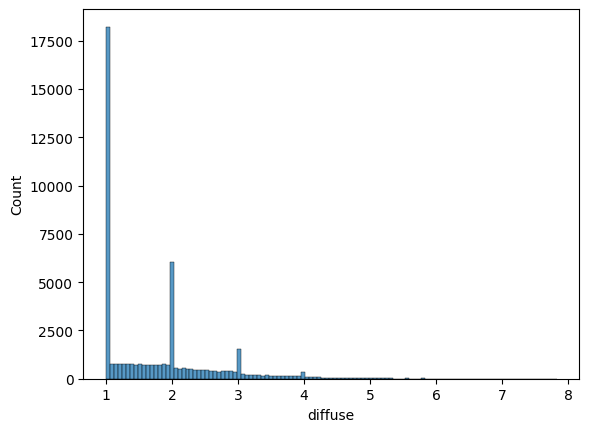

In [ ]:
sns.histplot(diffuse['diffuse'])

(6000, 2)


filename  label
400        wm_NA4626-02_AB_1536_22784_1792_23040_89.jpg      1
401        wm_NA4626-02_AB_1536_23040_1792_23296_90.jpg      1
402        wm_NA4626-02_AB_1792_23040_2048_23296_90.jpg      1
403        wm_NA4626-02_AB_1792_22784_2048_23040_89.jpg      1
404        wm_NA4626-02_AB_1792_23296_2048_23552_91.jpg      1
...                                                 ...    ...
5995  wm_NA5015-02_AB17-24_4352_46336_4608_46592_181...      1
5996  wm_NA5015-02_AB17-24_4352_46592_4608_46848_182...      1
5997  wm_NA5015-02_AB17-24_4352_42240_4608_42496_165...      1
5998  wm_NA5015-02_AB17-24_4352_42496_4608_42752_166...      1
5999  wm_NA5015-02_AB17-24_4352_42752_4608_43008_167...      1

[2000 rows x 2 columns]

<Axes: xlabel='label', ylabel='Count'>

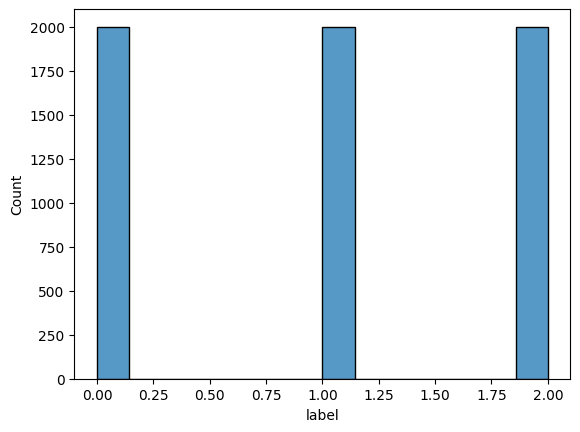

In [ ]:
import pandas as pd
import seaborn as sns
from IPython.display import display

train_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/wmgm/test.csv')
print(train_labels.shape)
display(train_labels[train_labels['label'] == 1])
sns.histplot(train_labels['label'])

Create small version of dataset CSV for debugging:

In [ ]:
plaque_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/hold-out.csv')
diffuse = plaque_labels[plaque_labels['diffuse'] > 0.99]
caa = plaque_labels[plaque_labels['CAA'] > 0.99]
cored = plaque_labels[plaque_labels['cored'] > 0.99]
positive_indices = (diffuse.index.union(caa.index)).union(cored.index)
negative = plaque_labels.iloc[plaque_labels.index.difference(positive_indices)]
#sample_indices = ((diffuse.head(5).index.union(caa.head(5).index)).union(cored.head(5).index)).union(negative.head(5).index)
#plaque_labels.iloc[sample_indices].to_csv('/content/drive/MyDrive/DeskBrainSec/tiles/validation-small.csv')

In [ ]:
len(negative)

330

In [ ]:
len(negative)

9761

In [ ]:
len(negative)

732

In [ ]:
tissue_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/wmgm-split/validation.csv')
bg = tissue_labels[tissue_labels['label'] == 0]
wm = tissue_labels[tissue_labels['label'] == 1]
gm = tissue_labels[tissue_labels['label'] == 2]
sample_indices = (bg.head(5).index.union(wm.head(5).index)).union(gm.head(5).index)
tissue_labels.iloc[sample_indices].to_csv('/content/drive/MyDrive/DeskBrainSec/wmgm-split/validation-small.csv')

# Datasets

(Only run once to split the WM/GM dataset)

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# split = (train_ratio, validation_ratio)
def split_wmgm_dataset(csvfile, img_dir, new_dir, split=(0.75, 0.14)):
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)

    wmgm_df = pd.read_csv(csvfile)
    # first extract training examples
    train_df, wmgm_df = train_test_split(wmgm_df, train_size=split[0], random_state=42, stratify=wmgm_df['label'])
    # then extract validation and holdout
    # of remaining examples, pull validation_ratio / (1 - training_ratio) for validation
    # the rest are holdout
    val_df, holdout_df = train_test_split(wmgm_df, train_size=split[1]/(1-split[0]), random_state=42, stratify=wmgm_df['label'])

    train_df.to_csv(os.path.join(new_dir, 'train.csv'))
    val_df.to_csv(os.path.join(new_dir, 'validation.csv'))
    holdout_df.to_csv(os.path.join(new_dir, 'hold-out.csv'))


    if not os.path.exists(os.path.join(new_dir, 'train')):
        os.mkdir(os.path.join(new_dir, 'train'))
    for f in train_df['filename']:
        shutil.copy(os.path.join(img_dir, f), os.path.join(new_dir, 'train', f))

    if not os.path.exists(os.path.join(new_dir, 'validation')):
        os.mkdir(os.path.join(new_dir, 'validation'))
    for f in val_df['filename']:
        shutil.copy(os.path.join(img_dir, f), os.path.join(new_dir, 'validation', f))

    if not os.path.exists(os.path.join(new_dir, 'hold-out')):
        os.mkdir(os.path.join(new_dir, 'hold-out'))
    for f in holdout_df['filename']:
        shutil.copy(os.path.join(img_dir, f), os.path.join(new_dir, 'hold-out', f))



In [ ]:
class WMGMDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.img_path = img_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        single_img_name = os.path.join(self.img_path, self.data.iloc[index]['filename'])
        label = self.data.iloc[index]['label']
        image = Image.open(os.path.join(self.img_path, single_img_name))

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Credit: https://github.com/keiserlab/plaquebox-paper/blob/master/2.1)%20CNN%20Models%20-%20Model%20Training%20and%20Development.ipynb

class PlaqueDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        c=torch.Tensor(self.data_info.loc[:,'cored'])
        d=torch.Tensor(self.data_info.loc[:,'diffuse'])
        a=torch.Tensor(self.data_info.loc[:,'CAA'])
        c=c.view(c.shape[0],1)
        d=d.view(d.shape[0],1)
        a=a.view(a.shape[0],1)
        self.raw_labels = torch.cat([c,d,a], dim=1)
        self.labels = (torch.cat([c,d,a], dim=1)>0.99).type(torch.FloatTensor)

    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        raw_label = self.raw_labels[index]
        # Get image name from the pandas df
        single_image_name = str(self.data_info.loc[index,'imagename'])
        # Open image
        img = Image.open(os.path.join(self.img_path, single_image_name))
        # Transform image to tensor
        if self.transform:
            img = self.transform(img)
        # Return image and the label
        return img, single_image_label

    def __len__(self):
        return len(self.data_info.index)

# Model Structure

In [ ]:
import torch.nn as nn
import torchvision
import torch

class PlaqueTissueClassifier(nn.Module):
    def __init__(self):
        super(PlaqueTissueClassifier, self).__init__()
        backbone = torchvision.models.mobilenet_v3_small(torchvision.models.MobileNet_V3_Small_Weights.DEFAULT)

        self.features = backbone.features
        self.avgpool = backbone.avgpool
        # plaque classes: diffuse, cored, CAA
        self.plaque_classifier = nn.Linear(backbone.classifier[0].in_features, 3)
        # tissue classes: white matter, gray matter, background
        self.tissue_classifier = nn.Linear(backbone.classifier[0].in_features, 3)

    # returns plaque and tissue predictions
    def forward(self, x):
        feats = self.features(x)
        feats = torch.flatten(self.avgpool(feats), 1)
        plaque = self.plaque_classifier(feats)
        tissue = self.tissue_classifier(feats)
        return plaque, tissue


# Training Script

## Training

In [ ]:
def train_step(model, optimizer, plaque_loader, tissue_loader, device,
				plaque_loss_fn, tissue_loss_fn, epoch, num_epochs, stat_count, scheduler):
	batch_losses = {"plaque": [], "tissue": []}
	# Set number of steps to fit larger dataset
	num_steps = max(len(plaque_loader), len(tissue_loader))
	# Get next batch from datasets
	for train_ct in range(num_steps):
		try:
			p_data = next(p_labelled_iter)
		except:
			p_labelled_iter = iter(plaque_loader)
			p_data = next(p_labelled_iter)
		try:
			t_data = next(t_labelled_iter)
		except:
			t_labelled_iter = iter(tissue_loader)
			t_data = next(t_labelled_iter)

		# Set to training mode
		with torch.enable_grad():
			model.train()
			# Move batch from the datasets to device
			t_images, t_labels = t_data[0].to(device,dtype=torch.float), t_data[1].to(device,dtype=torch.long)
			p_images, p_labels = p_data[0].to(device,dtype=torch.float), p_data[1].to(device,dtype=torch.long)
			# Reset optimizer
			optimizer.zero_grad()

			# Get plaque and tissue predictions for the batches
			p_preds, _ = model(p_images)
			_, t_preds = model(t_images)

			# Calculate plaque and tissue loss
			p_loss = plaque_loss_fn(p_preds, p_labels)
			t_loss = tissue_loss_fn(t_preds, t_labels)
			# Sum losses and update model weights
			loss = p_loss + t_loss
			loss.backward()

			# Record loss for each dataset
			batch_losses["plaque"].append(p_loss.item())
			batch_losses["tissue"].append(t_loss.item())

			# Update optimizer
			optimizer.step()
		# Print statistics on every stat_count iteration
		if (train_ct+1) % stat_count == 0:
			print('Epoch [%d/%d], Step [%d/%d], Plaque Loss: %.4f, Tissue Loss: %.4f'
									%(epoch+1, num_epochs, train_ct+1,
									num_steps, batch_losses["plaque"][-1],
									  batch_losses["tissue"][-1]))
	# Return loss at each step of epoch
	return batch_losses

## Evaluation

In [ ]:
def eval_step(model, plaque_loader, tissue_loader, device):
	# Set to inference mode
	with torch.no_grad():
		model.eval()

		# init metrics
		total_samples = {"plaque": 0, "tissue": 0}
		total_correct = {"plaque": 0, "tissue": 0}
		predictions = {"plaque": [], "tissue": []}
		labels = {"plaque": [], "tissue": []}

		# Plaque inference
		for p_data in plaque_loader:
			# Run inference on batch
			p_images, p_labels = p_data[0].to(device,dtype=torch.float), p_data[1].to(device,dtype=torch.long)
			p_preds, _ = model(p_images)
			# binarize the output of plaque prediction with threshold = 0.5
			# 2d tensor
			p_predicted = (torch.nn.functional.sigmoid(p_preds.data) > 0.5)
			# Record predictions and labels
			predictions["plaque"] = predictions["plaque"] + p_predicted.cpu().data.numpy().tolist()
			labels["plaque"] = labels["plaque"] + p_labels.cpu().data.numpy().tolist()

		# Tissue inference
		for t_data in tissue_loader:
			# Run inference on batch
			t_images, t_labels = t_data[0].to(device,dtype=torch.float), t_data[1].to(device,dtype=torch.long)
			_, t_preds = model(t_images)
			# Get tissue prediction from logit with highest probability
			# 1d tensor
			_, t_predicted = torch.max(t_preds.data, 1)
			# Record predictions and labels
			predictions["tissue"] = predictions["tissue"] + t_predicted.cpu().data.numpy().tolist()
			labels["tissue"] = labels["tissue"] + t_labels.cpu().data.numpy().tolist()

	return predictions, labels

## Calculate metrics for each dataset

In [ ]:
def calc_tissue_metrics(tissue_labels, tissue_predictions, set_name="Validation"):
    t_f1_score = f1_score(tissue_labels, tissue_predictions, average='micro', zero_division=0)
    t_acc_score = accuracy_score(tissue_labels, tissue_predictions)
    t_bacc_score = balanced_accuracy_score(tissue_labels, tissue_predictions)

    print("-" * 40)
    print(set_name, "Tissue Dataset:")
    print("Accuracy = ", t_acc_score)
    print("Balanced Accuracy = ", t_bacc_score)
    print("Micro F1 = ", t_f1_score)

    return t_f1_score, t_acc_score, t_bacc_score

In [ ]:
def calc_plaque_metrics(plaque_labels, plaque_predictions, set_name="Validation"):
    p_f1_score = f1_score(plaque_labels, plaque_predictions, average='samples', zero_division=0)

    p_bacc_scores = np.zeros(3)
    for col in range(3):
        p_bacc_scores[col] = balanced_accuracy_score(plaque_labels[:][col], plaque_predictions[:][col])
    p_bacc_score = np.mean(p_bacc_scores)

    # Calculate sample-wise accuracy to compare with plaque-box paper
    p_predictions = np.array(plaque_predictions)
    p_labels = np.array(plaque_labels)
    p_correct = np.apply_over_axes(np.sum, p_predictions == p_labels, [0,1])
    p_sample_acc_score = float(p_correct) / (p_labels.shape[0] * p_labels.shape[1])

    print("-" * 40)
    print(set_name, "Plaque Dataset:")
    print("Sample-wise Accuracy = ", p_sample_acc_score)
    print("Balanced Accuracy = ", p_bacc_score)
    print("Sample F1 = ", p_f1_score)

    return p_f1_score, p_sample_acc_score, p_bacc_score

## Save graphs of metrics



In [ ]:
def save_metric_fig(metric_data, metric_names, title, filename, base_dir):
    fig, ax = plt.subplots()
    # iterate over each metric in metric_data
    for i in range(len(metric_data)):
        # plot (epoch, metric) pair
        plt.plot(metric_data[i], label=metric_names[i])
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel("Epochs")
    fig.savefig(os.path.join(base_dir, filename))

def save_metric_figs(file_prefix, loss_epoch, acc_train_epoch, acc_val_epoch,
                     bacc_train_epoch, bacc_val_epoch, f1_train_epoch, f1_val_epoch,
                     base_dir):
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)

    # Save loss metrics
    save_metric_fig([loss_epoch["plaque"]], ["loss"], "Tissue Loss", file_prefix+'_tissue_loss.png', base_dir)
    save_metric_fig([loss_epoch["tissue"]], ["loss"], "Plaque Loss", file_prefix+'_plaque_loss.png', base_dir)

    # Save accuracy metrics
    save_metric_fig([acc_train_epoch["plaque"], acc_val_epoch["plaque"]],
                ["train acc", "val acc"], "Plaque Accuracy", file_prefix+'_plaque_acc.png', base_dir)
    save_metric_fig([acc_train_epoch["tissue"], acc_val_epoch["tissue"]],
                ["train acc", "val acc"], "Tissue Accuracy", file_prefix+'_tissue_acc.png', base_dir)

    save_metric_fig([f1_train_epoch["plaque"], f1_val_epoch["plaque"]],
                ["train f1-score", "val f1-score"], "Plaque F1-Score", file_prefix+'_plaque_f1.png', base_dir)
    save_metric_fig([f1_train_epoch["tissue"], f1_val_epoch["tissue"]],
                ["train f1-score", "val f1-score"], "Tissue F1-Score", file_prefix+'_tissue_f1.png', base_dir)

    save_metric_fig([bacc_train_epoch["plaque"], bacc_val_epoch["plaque"]],
                ["train bacc", "val bacc"], "Plaque Balanced Accuracy", file_prefix+'_plaque_bacc.png', base_dir)
    save_metric_fig([bacc_train_epoch["tissue"], bacc_val_epoch["tissue"]],
                ["train bacc", "val bacc"], "Tissue Balanced Accuracy", file_prefix+'_tissue_bacc.png', base_dir)


In [ ]:
def find_checkpoint(base_dir, model_name):
    checkpoint_list = glob.glob(os.path.join(base_dir, "checkpoints", f"{model_name}_Epoch_*.pth"))
    max_epoch = 0
    for name in checkpoint_list:
        name_components = name.split("_")
        epoch = name_components[name_components.index("Epoch") + 1]
        max_epoch = max(int(epoch.split(".")[0]), max_epoch)
    return os.path.join(base_dir, "checkpoints", f"{model_name}_Epoch_{max_epoch}.pth")


## Full training script

In [ ]:
def fit(model_name, model, optimizer, plaque_train_loader, plaque_val_loader,
        tissue_train_loader, tissue_val_loader, num_epochs, base_dir, load_checkpoint = False,
        stat_count=10, gpu=0):

    # Move model to device
    device = torch.device('cuda:'+str(gpu) if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Optionally load checkpoint
    if load_checkpoint:
        load_path = find_checkpoint(base_dir, model_name)
        checkpoint = torch.load(load_path, weights_only=False)
        # load model params
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        # set metrics based on checkpoint
        curr_model_score = checkpoint['model_score']
        loss_epoch = checkpoint['metrics']['loss_epoch']
        acc_train_epoch = checkpoint['metrics']['acc_train_epoch']
        acc_val_epoch = checkpoint['metrics']['acc_val_epoch']
        f1_val_epoch = checkpoint['metrics']['f1_val_epoch']
        f1_train_epoch = checkpoint['metrics']['f1_train_epoch']
        bacc_val_epoch = checkpoint['metrics']['bacc_val_epoch']
        bacc_train_epoch = checkpoint['metrics']['bacc_train_epoch']

    else:
        start_epoch = 0
        # Init to collect metrics during training
        curr_model_score = 0
        loss_epoch = {"plaque": [], "tissue": []}
        acc_train_epoch = {"plaque": [], "tissue": []}
        acc_val_epoch = {"plaque": [], "tissue": []}
        f1_val_epoch = {"plaque": [], "tissue": []}
        f1_train_epoch = {"plaque": [], "tissue": []}
        bacc_val_epoch = {"plaque": [], "tissue": []}
        bacc_train_epoch = {"plaque": [], "tissue": []}

    # Init Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Set loss functions for tissue and plaque data
    plaque_loss_fn = nn.MultiLabelSoftMarginLoss()
    tissue_loss_fn = nn.CrossEntropyLoss()

    # Train until reaching specified number of epochs
    for epoch in range(start_epoch, num_epochs):
        print("Epoch Number", epoch)
        start_time = time.time()
        # TRAINING STEP
        batch_losses = train_step(model, optimizer, plaque_train_loader, tissue_train_loader,
                                device, plaque_loss_fn, tissue_loss_fn, epoch, num_epochs, stat_count)

        # VALIDATION STEP
        val_metrics = eval_step(model, plaque_val_loader, tissue_val_loader, device)
        val_predictions = val_metrics[0]
        val_labels = val_metrics[1]

        # TRAINING EVALUATION STEP
        train_metrics = eval_step(model, plaque_train_loader, tissue_train_loader, device)
        train_predictions = train_metrics[0]
        train_labels = train_metrics[1]

        print("Epoch time:", time.time() - start_time)
        # Save avg loss
        loss_epoch["plaque"].append(mean(batch_losses["plaque"]))
        loss_epoch["tissue"].append(mean(batch_losses["tissue"]))
        # Step LR scheduler
        scheduler.step()

        # Save tissue validation metrics
        t_val_metrics = calc_tissue_metrics(val_predictions["tissue"], val_labels["tissue"], set_name='Validation')
        f1_val_epoch["tissue"].append(t_val_metrics[0])
        acc_val_epoch["tissue"].append(t_val_metrics[1])
        bacc_val_epoch["tissue"].append(t_val_metrics[2])
        # Save tissue train metrics
        t_train_metrics = calc_tissue_metrics(train_predictions["tissue"], train_labels["tissue"], set_name='Train')
        f1_train_epoch["tissue"].append(t_train_metrics[0])
        acc_train_epoch["tissue"].append(t_train_metrics[1])
        bacc_train_epoch["tissue"].append(t_train_metrics[2])

        # Save plaque validation metrics
        p_val_metrics = calc_plaque_metrics(val_predictions["plaque"], val_labels["plaque"], set_name='Validation')
        f1_val_epoch["plaque"].append(p_val_metrics[0])
        acc_val_epoch["plaque"].append(p_val_metrics[1])
        bacc_val_epoch["plaque"].append(p_val_metrics[2])
        # Save plaque training metrics
        p_train_metrics = calc_plaque_metrics(train_predictions["plaque"], train_labels["plaque"], set_name='Train')
        f1_train_epoch["plaque"].append(p_train_metrics[0])
        acc_train_epoch["plaque"].append(p_train_metrics[1])
        bacc_train_epoch["plaque"].append(p_train_metrics[2])

        # Save checkpoint if avg of balanced accuracy of tissue and plaque improves
        if curr_model_score < bacc_val_epoch["tissue"][-1] * bacc_val_epoch["plaque"][-1]:
            curr_model_score = bacc_val_epoch["tissue"][-1] * bacc_val_epoch["plaque"][-1]
            if not os.path.exists(os.path.join(base_dir, 'checkpoints')):
                os.mkdir(os.path.join(base_dir, 'checkpoints'))
            torch.save(
                {
                    'epoch': epoch,
                    'model_score': curr_model_score,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'metrics': {
                        'loss_epoch': loss_epoch,
                        'acc_train_epoch': acc_train_epoch,
                        'acc_val_epoch': acc_val_epoch,
                        'f1_train_epoch': f1_train_epoch,
                        'f1_val_epoch': f1_val_epoch,
                        'bacc_train_epoch': bacc_train_epoch,
                        'bacc_val_epoch': bacc_val_epoch
                    }

                },
                os.path.join(base_dir, 'checkpoints', f"{model_name}_Epoch_{epoch}.pth")
            )
            print("Model checkpoint saved.")
        print("\n")

    # use model name, first epoch idx, and last epoch idx to identify
    plot_file_prefix = f"{model_name}_EpochRange_{start_epoch}_{num_epochs - 1}"
    # After training finishes
    save_metric_figs(plot_file_prefix, loss_epoch, acc_train_epoch, acc_val_epoch,
                     bacc_train_epoch, bacc_val_epoch, f1_train_epoch, f1_val_epoch,
                     os.path.join(base_dir, 'training_plots'))

    return loss_epoch, acc_train_epoch, acc_val_epoch, curr_model_score

# Run Training

## Parameters

In [ ]:
BATCH_SIZE = 128
WORKERS = 2
LR = 0.001
BASE_DIR = '/content/'
EPOCHS = 10
DEBUG = False
USE_CHECKPOINT = False

## Datasets

In [ ]:
from torchvision import transforms

plaque_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(0.1),
    transforms.RandomVerticalFlip(0.1),
    transforms.RandomRotation(15),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

wmgm_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),

    # Normalize for pretrained weights
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Normalize for pretrained weights
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:
plaque_dir = "/content/tiles"
wmgm_dir = "/content/wmgm-split"

if DEBUG:
    plaque_train_set= PlaqueDataset(os.path.join(plaque_dir, 'train-small-imbalance.csv'), os.path.join(plaque_dir, 'train'), transform=plaque_transform)
    plaque_val_set= PlaqueDataset(os.path.join(plaque_dir, 'validation-small-imbalance.csv'), os.path.join(plaque_dir, 'validation'), transform=test_transform)
    wmgm_train_set= WMGMDataset(os.path.join(wmgm_dir, 'train-small.csv'), os.path.join(wmgm_dir, 'train'), transform=wmgm_transform)
    wmgm_val_set= WMGMDataset(os.path.join(wmgm_dir, 'validation-small.csv'), os.path.join(wmgm_dir, 'validation'), transform=test_transform)
else:
    plaque_train_set= PlaqueDataset(os.path.join(plaque_dir, 'train.csv'), os.path.join(plaque_dir, 'train'), transform=plaque_transform)
    plaque_val_set= PlaqueDataset(os.path.join(plaque_dir, 'validation.csv'), os.path.join(plaque_dir, 'validation'), transform=test_transform)
    wmgm_train_set= WMGMDataset(os.path.join(wmgm_dir, 'train.csv'), os.path.join(wmgm_dir, 'train'), transform=wmgm_transform)
    wmgm_val_set= WMGMDataset(os.path.join(wmgm_dir, 'validation.csv'), os.path.join(wmgm_dir, 'validation'), transform=test_transform)


In [ ]:
print(len(wmgm_train_set))
print(len(plaque_train_set))

# Plaque has multiple labels (cored, diffuse, etc), want to balance them
# wmgm has only one label but few datapoints, want to do more transforms to it

print(wmgm_train_set[0])
print(plaque_train_set[0])
"""
s = set()
for i in range(1000):
  s.add(tuple(plaque_train_set[i][1].tolist()))
  if i % 100 == 99:
    print(i)


print(s)
"""

print(plaque_train_set.labels)
np.where(plaque_train_set.labels[:, 0] == 1)[0].shape

4500
61370
(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-1.2274, -0.6965,  0.5536,  ..., -2.1179, -2.1179, -2.1179],
         [-1.4158, -1.0390,  0.0398,  ..., -2.1179, -2.1179, -2.1179],
         [-1.5185, -1.1932, -0.2171,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-1.1253, -0.5826,  0.6779,  ..., -2.0357, -2.0357, -2.0357],
         [-1.3179, -0.9328,  0.1527,  ..., -2.0357, -2.0357, -2.0357],
         [-1.4230, -1.0903, -0.0924,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.80

(2141,)

## Dataloaders

In [ ]:
# Define a sampler for plaque dataset to oversample minority classes
class_sample_count = np.array(
    [len(np.where(plaque_train_set.labels[:, t] == 1)[0]) for t in range(3)])

print([len(np.where(plaque_train_set.labels[:, t] == 1)[0]) for t in range(3)])
print(class_sample_count)
weight = 1. / class_sample_count
weight /= np.linalg.norm(weight)
print(weight)
samples_weight = np.array([max(weight * t) for t in plaque_train_set.labels.numpy()])
print(len(samples_weight), samples_weight)
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

[4, 81, 3]
[ 4 81  3]
[0.5997368  0.02961663 0.79964907]
100 [0.5997368  0.5997368  0.5997368  0.5997368  0.79964907 0.79964907
 0.79964907 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 

In [ ]:
plaque_train_loader = DataLoader(plaque_train_set, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=WORKERS)
plaque_val_loader = DataLoader(plaque_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
wmgm_train_loader = DataLoader(wmgm_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
wmgm_val_loader = DataLoader(wmgm_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [ ]:
len(plaque_train_loader)

1

### Show augmentations on images in dataloader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(data_loader, freq=True):
    x, y = next(iter(data_loader))  # Take one batch
    if freq:
      print([len(np.where(y[:, t] == 1)[0]) for t in range(3)])
    print(y.shape)
    print(y)
    print(np.unique(y))
    batch_size = x.size(0)
    grid_size = int(batch_size ** 0.5)
    if grid_size ** 2 < batch_size:
        grid_size += 1

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    axes = np.ravel(axes)
    print(x[0].shape)

    for i, ax in enumerate(axes):
        if i < batch_size:
            image = x[i].numpy()
            image_min = image.min()
            image_max = image.max()
            image = (image - image_min) / (image_max - image_min)
            image = image.transpose(1, 2, 0)
            ax.imshow(image, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

Show Plaque Batch

[9, 8, 8]
torch.Size([20, 3])
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])
[0. 1.]
torch.Size([3, 256, 256])


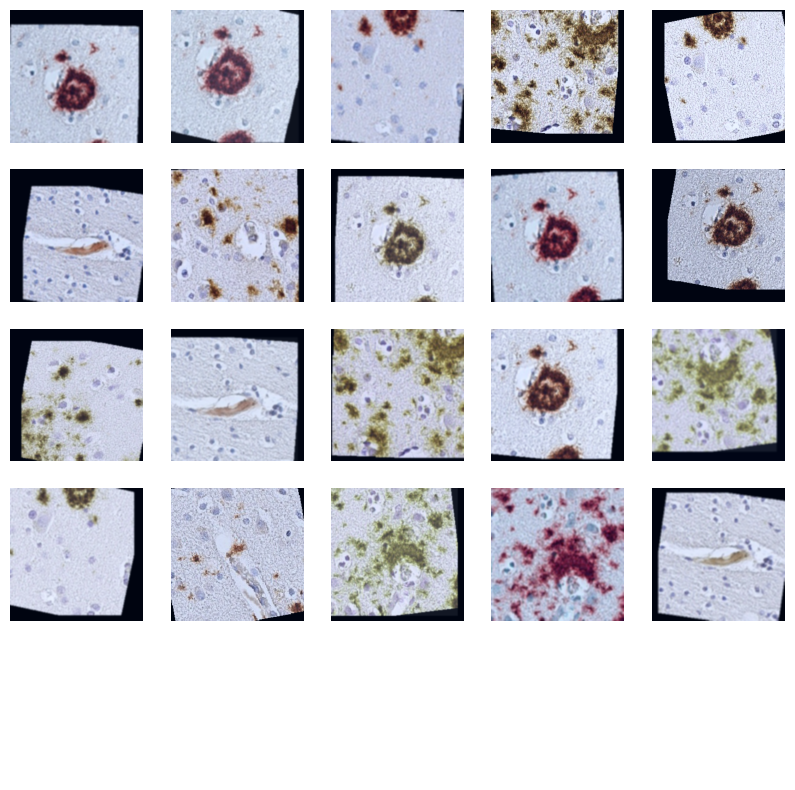

In [ ]:
show_batch(plaque_train_loader)

Show WM/GM Batch

torch.Size([20])
tensor([2, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 2])
[0 1 2]
torch.Size([3, 256, 256])


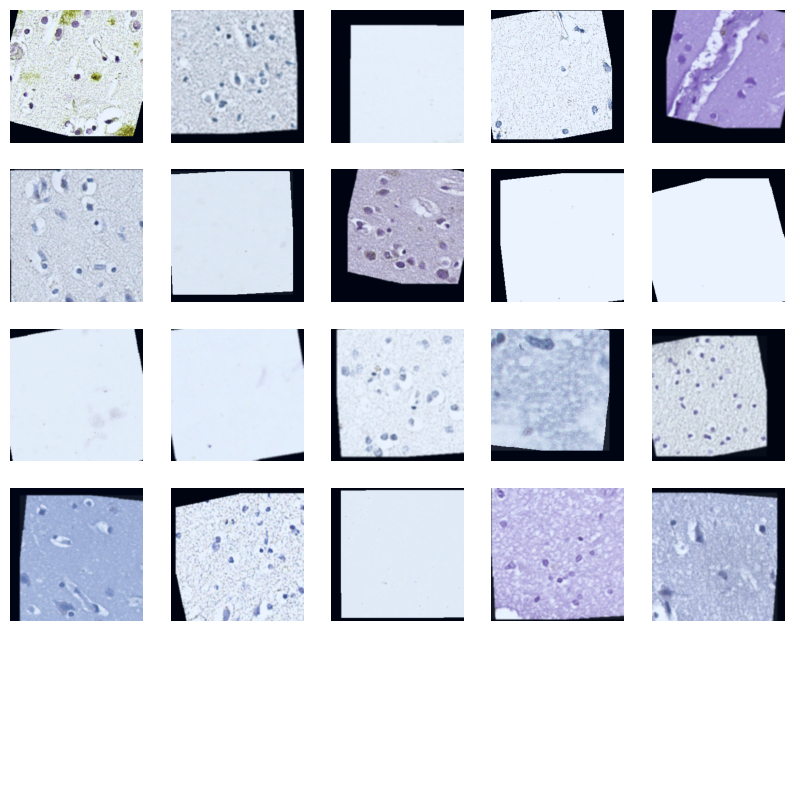

In [ ]:
show_batch(wmgm_train_loader, freq=False)

## Run Full Training

Epoch Number 0
Epoch time: 5.782310485839844
----------------------------------------
Validation Tissue Dataset:
Accuracy =  0.6666666666666666
Balanced Accuracy =  0.75
Micro F1 =  0.6666666666666666
----------------------------------------
Train Tissue Dataset:
Accuracy =  0.64
Balanced Accuracy =  0.764720374476472
Micro F1 =  0.64
----------------------------------------
Validation Plaque Dataset:
Sample-wise Accuracy =  0.35
Balanced Accuracy =  0.25
Sample F1 =  0.0
----------------------------------------
Train Plaque Dataset:
Sample-wise Accuracy =  0.7
Balanced Accuracy =  1.0
Sample F1 =  0.5366666666666666
Model checkpoint saved.


Epoch Number 1
Epoch time: 4.564937353134155
----------------------------------------
Validation Tissue Dataset:
Accuracy =  0.6666666666666666
Balanced Accuracy =  0.75
Micro F1 =  0.6666666666666666
----------------------------------------
Train Tissue Dataset:
Accuracy =  0.68
Balanced Accuracy =  0.7926267281105991
Micro F1 =  0.68
-----------

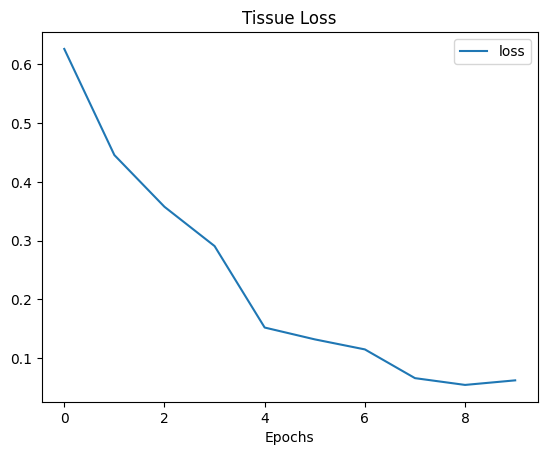

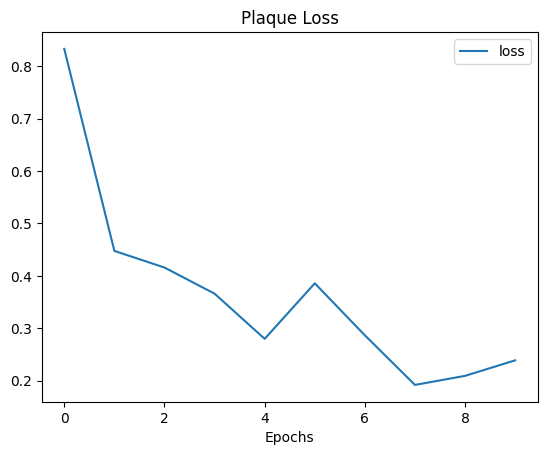

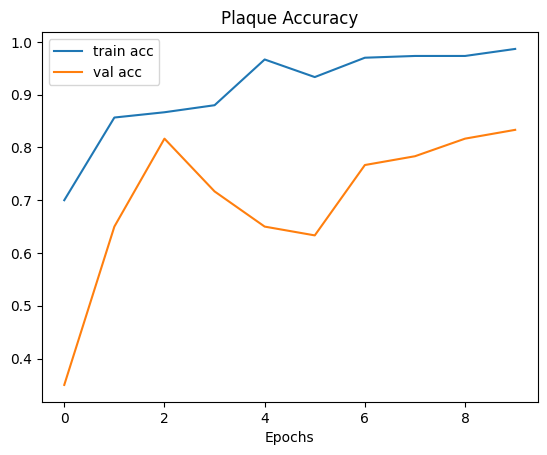

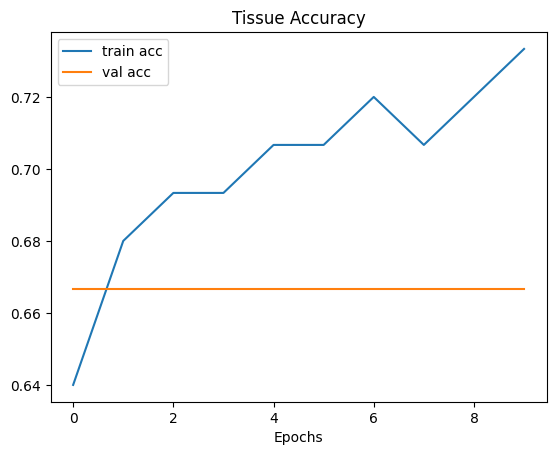

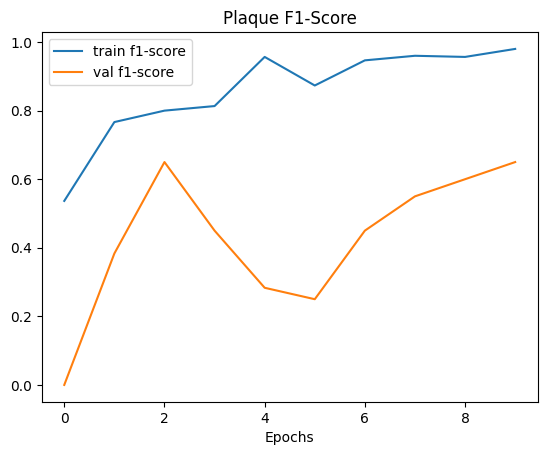

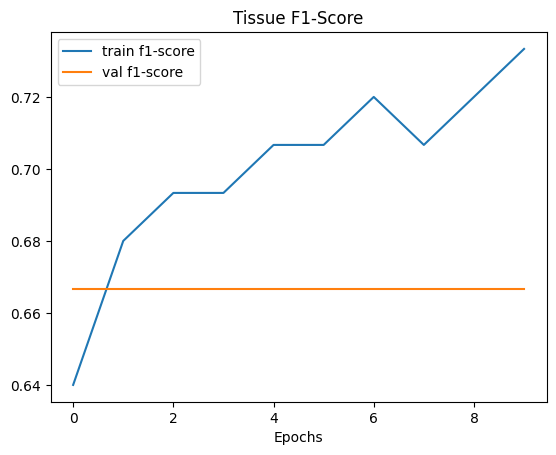

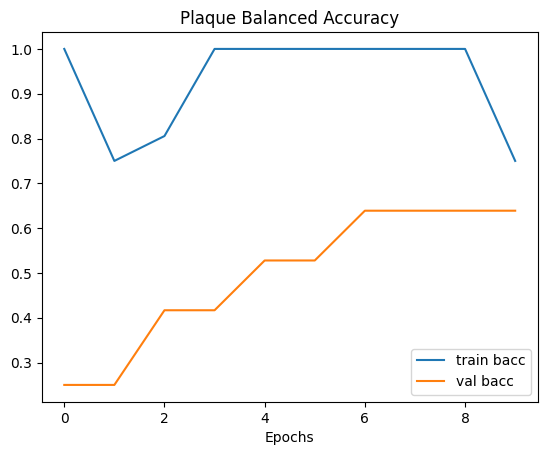

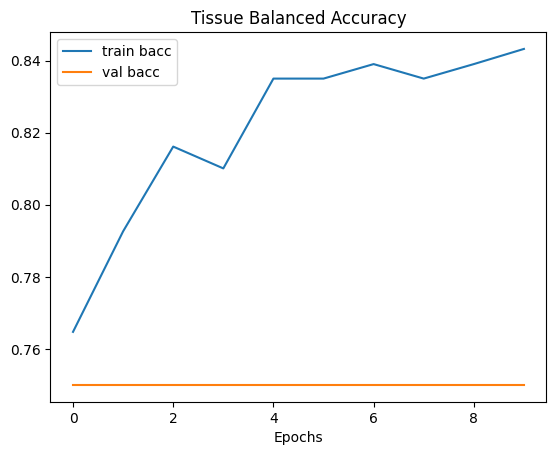

In [ ]:
model = PlaqueTissueClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if DEBUG:
    model_name = "PlaqueTissueClassifierDebug"
else:
    model_name = "PlaqueTissueClassifier"

loss, acc_train, acc_val, model_score = fit(model_name, model, optimizer, plaque_train_loader,
                                        plaque_val_loader, wmgm_train_loader, wmgm_val_loader,
                                        EPOCHS, BASE_DIR, USE_CHECKPOINT)

In [ ]:
print(model_score)

0.47916666666666663


# Inference

In [ ]:
def get_class_cm(labels_list, preds_list):
    class_cm = []
    for i in range(len(labels_list[0])):
        class_labels = [l[i] for l in labels_list]
        class_preds = [p[i] for p in preds_list]
        class_cm.append(confusion_matrix(class_labels, class_preds))
    return class_cm

In [ ]:
def test_holdout(model, plaque_holdout_loader, tissue_holdout_loader, base_dir):
    f1_holdout, acc_holdout, bacc_holdout = dict(), dict(), dict()
    holdout_metrics = eval_step(model, plaque_holdout_loader, tissue_holdout_loader, 'cpu')
    holdout_predictions = holdout_metrics[0]
    holdout_labels = holdout_metrics[1]

    # Save tissue validation metrics
    t_holdout_metrics = calc_tissue_metrics(holdout_predictions["tissue"], holdout_labels["tissue"], set_name='Holdout')
    f1_holdout["tissue"] = t_holdout_metrics[0]
    acc_holdout["tissue"] = t_holdout_metrics[1]
    bacc_holdout["tissue"] = t_holdout_metrics[2]

    # Save plaque validation metrics
    p_holdout_metrics = calc_plaque_metrics(holdout_predictions["plaque"], holdout_labels["plaque"], set_name='Holdout')
    f1_holdout["plaque"] = p_holdout_metrics[0]
    acc_holdout["plaque"] = p_holdout_metrics[1]
    bacc_holdout["plaque"] = p_holdout_metrics[2]
    #print("f1 per class:", f1_score(holdout_labels["plaque"], holdout_predictions["plaque"], average=None))
    plaque_cm = get_class_cm(holdout_labels["plaque"], holdout_predictions["plaque"])

    return f1_holdout, acc_holdout, bacc_holdout, plaque_cm


In [ ]:
BASE_DIR = '/content/drive/MyDrive/DeskBrainSec'
BATCH_SIZE = 128

Load model with weights from training. Kaggle models are trained on 2x T4 GPUs. We need to convert to CPU model and remove `module.` prefix added from DataParallel wrapper.

In [ ]:
test_checkpoint = '/content/checkpoints/PlaqueTissueClassifier_Epoch_0.pth'

In [ ]:
model = PlaqueTissueClassifier().to('cpu')
checkpoint_path = os.path.join(BASE_DIR, test_checkpoint)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

new_state_dict = dict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace('module.', '') # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
plaque_dir = "/content/tiles"
wmgm_dir = "/content/wmgm-split"

plaque_holdout_set = PlaqueDataset(os.path.join(plaque_dir, 'hold-out.csv'), os.path.join(plaque_dir, 'hold-out'), transform=test_transform)
wmgm_holdout_set= WMGMDataset(os.path.join(wmgm_dir, 'hold-out.csv'), os.path.join(wmgm_dir, 'hold-out'), transform=test_transform)

plaque_holdout_loader = DataLoader(plaque_holdout_set, batch_size=BATCH_SIZE, shuffle=False)
wmgm_holdout_loader = DataLoader(wmgm_holdout_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
f1, acc, bacc, class_cm = test_holdout(model, plaque_holdout_loader, wmgm_holdout_loader, BASE_DIR)

----------------------------------------
Holdout Tissue Dataset:
Accuracy =  0.953030303030303
Balanced Accuracy =  0.9580941567316387
Micro F1 =  0.953030303030303
----------------------------------------
Holdout Plaque Dataset:
Sample-wise Accuracy =  0.9677795150065912
Balanced Accuracy =  1.0
Sample F1 =  0.9310524540911738


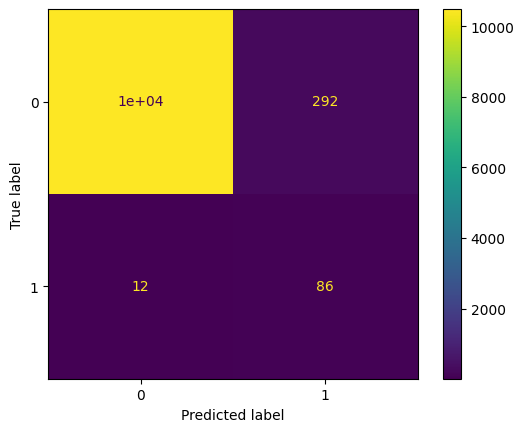

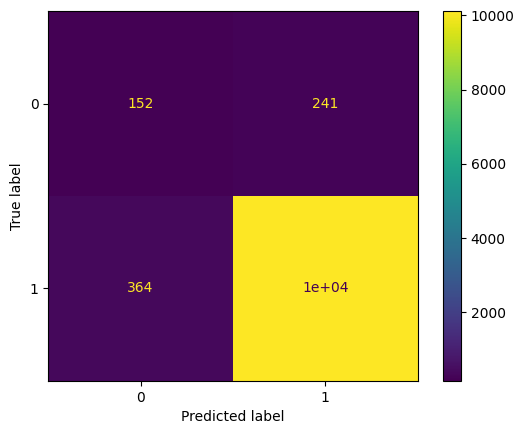

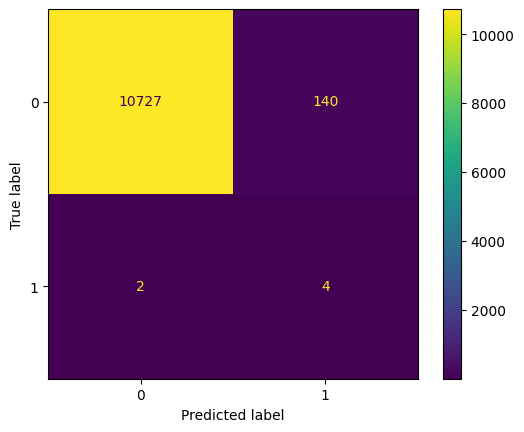

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
for cm in class_cm:
    ConfusionMatrixDisplay(cm).plot()

In [ ]:
model_debug = PlaqueTissueClassifier().to('cpu')
checkpoint_path = os.path.join(BASE_DIR, 'checkpoints/PlaqueTissueClassifierDebug_Epoch_7.pth')
checkpoint = torch.load(checkpoint_path)
model_debug.load_state_dict(checkpoint['model_state_dict'])
f1_debug, acc_debug, bacc_debug = test_holdout(model_debug, plaque_holdout_loader, wmgm_holdout_loader, BASE_DIR)

----------------------------------------
Holdout Tissue Dataset:
Accuracy =  0.7848484848484848
Balanced Accuracy =  0.8381240915214834
Micro F1 =  0.7848484848484848
----------------------------------------
Holdout Plaque Dataset:
Sample-wise Accuracy =  0.7554799350072043
Balanced Accuracy =  1.0
Sample F1 =  0.6213556516140899


In [ ]:
# 0: cored, 1: diffuse, 2: CAA
def count_classes(dataset):
    counts = np.array([len(np.where(dataset.labels[:, t] == 1)[0]) for t in range(3)])
    return counts

In [ ]:
print(count_classes(plaque_holdout_set))
print(count_classes(plaque_train_set))
print(count_classes(plaque_val_set))

[   98 10480     6]
[ 2141 48123  2227]
[ 381 7487  126]
